In [1]:
!pip install category_encoders

  Using cached category_encoders-2.6.2-py2.py3-none-any.whl (81 kB)


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.5 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import easydict
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder




args = easydict.EasyDict()
sns.set_theme(style="darkgrid")

args.default_path = './data/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0220.csv'
args.save_results = args.default_path+"result/model_results.json"
args.random_state = 21
args.results = []

plt.style.use('fivethirtyeight')
plt.ion()

warnings.filterwarnings('ignore')

ori_train = pd.read_csv(args.train_csv) # train file read and make data frame
ori_test = pd.read_csv(args.test_csv) #  test file read and make data frame
submission = pd.read_csv(args.default_submission_csv) #

#print(ori_train.head())
ori_test.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [4]:
ori_train.isnull().sum().sort_values(ascending=False)  / ori_train.shape[0]

cabin          0.783843
age            0.196507
embarked       0.001092
passengerid    0.000000
survived       0.000000
pclass         0.000000
name           0.000000
gender         0.000000
sibsp          0.000000
parch          0.000000
ticket         0.000000
fare           0.000000
dtype: float64

## 함수 정의

In [5]:
def sub_age(age):
  return age // 10

def sub_sibsp(sibsp):
  if(sibsp==0):
    return 0
  elif(sibsp == 1):
    return 1
  else:
    return 2
def sub_parch(parch):
  if(parch==0):
    return 0
  else:
    return 1

## find_s_survived columns 확인

In [6]:
find_s_survived = ori_train[['passengerid', 'pclass','age','fare', 'gender','parch','sibsp', 'survived', 'embarked']]

In [7]:
find_s_survived.isnull().sum()

passengerid      0
pclass           0
age            180
fare             0
gender           0
parch            0
sibsp            0
survived         0
embarked         1
dtype: int64

In [8]:
ori_test.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             1
cabin          296
embarked         1
dtype: int64

## null 지우기

In [9]:
mean_age = find_s_survived['age'].mean()

find_s_survived['age'].fillna(mean_age, inplace=True)
ori_test['age'].fillna(mean_age, inplace=True)

In [10]:
mean_age = find_s_survived['fare'].mean()

find_s_survived['fare'].fillna(mean_age, inplace=True)
ori_test['fare'].fillna(mean_age, inplace=True)

In [11]:
embarked_mode = find_s_survived['embarked'].mode().values[0]

find_s_survived['embarked'].fillna(embarked_mode, inplace=True)
ori_test['embarked'].fillna(embarked_mode, inplace=True)

## 범주형 데이터 형변환

In [12]:
'''find_s_survived['sub_age'] = find_s_survived['age'].map(lambda x: sub_age(x))
find_s_survived['sub_age'] = find_s_survived['sub_age'].astype("category")

ori_test['sub_age'] = ori_test['age'].map(lambda x: sub_age(x))
ori_test['sub_age'] = ori_test['sub_age'].astype("category")'''

'find_s_survived[\'sub_age\'] = find_s_survived[\'age\'].map(lambda x: sub_age(x))\nfind_s_survived[\'sub_age\'] = find_s_survived[\'sub_age\'].astype("category")\n\nori_test[\'sub_age\'] = ori_test[\'age\'].map(lambda x: sub_age(x))\nori_test[\'sub_age\'] = ori_test[\'sub_age\'].astype("category")'

In [13]:
find_s_survived['sub_parch'] = find_s_survived['parch'].map(lambda x: sub_parch(x))
find_s_survived['sub_parch'] = find_s_survived['sub_parch'].astype("category")

ori_test['sub_parch'] = ori_test['parch'].map(lambda x: sub_parch(x))
ori_test['sub_parch'] = ori_test['sub_parch'].astype("category")

In [14]:
find_s_survived['sub_sibsp'] = find_s_survived['sibsp'].map(lambda x: sub_sibsp(x))
find_s_survived['sub_sibsp'] = find_s_survived['sub_sibsp'].astype("category")

ori_test['sub_sibsp'] = ori_test['sibsp'].map(lambda x: sub_sibsp(x))
ori_test['sub_sibsp'] = ori_test['sub_sibsp'].astype("category")

In [15]:
find_s_survived = find_s_survived.drop(columns=['parch'])
#find_s_survived = find_s_survived.drop(columns=['age'])
find_s_survived = find_s_survived.drop(columns=['sibsp'])

#ori_test = ori_test.drop(columns=['passengerid'])
#ori_test = ori_test.drop(columns=['age'])
ori_test = ori_test.drop(columns=['sibsp'])
ori_test = ori_test.drop(columns=['ticket'])
ori_test = ori_test.drop(columns=['cabin'])

In [16]:
no_category_cols = ['passengerid','age', 'survived', 'fare']
category_cols = ['pclass', 'gender', 'sub_parch','sub_sibsp', 'embarked']

train_no_category = find_s_survived[no_category_cols]
train_category = find_s_survived[category_cols]

train_no_category.shape, train_category.shape

((916, 4), (916, 5))

In [17]:
no_category_cols = ['passengerid','age', 'fare']
category_cols = ['pclass', 'gender', 'sub_parch','sub_sibsp', 'embarked']

test_no_category = ori_test[no_category_cols]
test_category = ori_test[category_cols]

test_no_category.shape, test_category.shape

((393, 3), (393, 5))

In [18]:
train_category['gender'] = train_category['gender'].map({'male':1, 'female':2}).astype('category')
train_category['pclass'] = train_category['pclass'].astype('category')
train_category['sub_parch'] = train_category['sub_parch'].astype('category')
train_category['sub_sibsp'] = train_category['sub_sibsp'].astype('category')

test_category['gender'] = test_category['gender'].map({'male':1, 'female':2}).astype('category')
test_category['pclass'] = test_category['pclass'].astype('category')
test_category['sub_parch'] = test_category['sub_parch'].astype('category')
test_category['sub_sibsp'] = test_category['sub_sibsp'].astype('category')

## 수치형 스케일링

In [19]:
# 스케일링 적용할 컬럼 선언
scaling_cols = ['passengerid','fare','age']

# 수치형 데이터 프레임에서 스케일링 적용할 컬럼이 포함된 데이터 프레임 생성
train_scaling = train_no_category[scaling_cols]
test_scaling = test_no_category[scaling_cols]

print(f'{train_scaling.shape} / {test_scaling.shape}')
train_scaling.head(3)

(916, 3) / (393, 3)


,passengerid,fare,age
0,0,12.875,29.69837
1,1,7.750,29.69837
2,2,93.500,52.00000


In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
# 인스턴스 생성
std = StandardScaler()

In [22]:
# 학습
std.fit(train_scaling)

StandardScaler()

In [23]:
# 반영
X_train_scaled = std.transform(train_scaling)
X_test_scaled = std.transform(test_scaling)

In [24]:
X_train_scaled.shape, X_test_scaled.shape

((916, 3), (393, 3))

In [25]:
train_scaling.shape, test_scaling.shape

((916, 3), (393, 3))

## 수치형, 범주형 합치기

In [26]:
_train_encoded = pd.DataFrame()
_test_encoded = pd.DataFrame()

for col in ['pclass', 'gender', 'sub_parch', 'embarked']:
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(train_category[col])
  _encoded = _encoder.transform(train_category[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

  _encoded = _encoder.transform(test_category[col])
  _test_encoded = pd.concat([_test_encoded, _encoded], axis=1)

In [27]:
train_encoded = pd.concat([train_no_category, _train_encoded], axis=1)
train_encoded.shape

(916, 14)

In [28]:
train_encoded

,passengerid,age,survived,fare,pclass_2.0,pclass_3.0,pclass_1.0,gender_1.0,gender_2.0,sub_parch_0.0,sub_parch_1.0,embarked_S,embarked_Q,embarked_C
0,0,29.69837,0,12.8750,1,0,0,1,0,1,0,1,0,0
1,1,29.69837,0,7.7500,0,1,0,0,1,1,0,0,1,0
2,2,52.00000,1,93.5000,0,0,1,0,1,0,1,1,0,0
3,3,27.00000,1,7.7958,0,1,0,1,0,1,0,1,0,0
4,4,44.00000,0,26.0000,1,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,911,29.69837,0,6.4375,0,1,0,1,0,1,0,0,0,1
912,912,18.00000,0,8.6625,0,1,0,1,0,1,0,1,0,0
913,913,19.00000,0,10.5000,1,0,0,1,0,1,0,1,0,0
914,914,29.69837,1,7.7333,0,1,0,0,1,1,0,0,1,0


In [29]:
test_encoded = pd.concat([test_no_category, _test_encoded], axis=1)
test_encoded.shape

(393, 13)

In [30]:
train_encoded.isnull().sum().sum(), test_encoded.isnull().sum().sum()

(0, 0)

In [31]:
train_target = train_encoded['survived']
train_features = train_encoded.drop(columns=['survived'])

train_features.shape, train_target.shape

((916, 13), (916,))

# K-Fold

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [33]:
# 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

## DecisionTree

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
model = DecisionTreeClassifier(random_state=42)

n_iter = 0
auc_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred_proba = model.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가

print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

1 번째 Stratified Stratified K-Fold 정확도: 0.7913533834586467
2 번째 Stratified Stratified K-Fold 정확도: 0.7572463768115942
3 번째 Stratified Stratified K-Fold 정확도: 0.8180778032036614
4 번째 Stratified Stratified K-Fold 정확도: 0.7818459191456903
5 번째 Stratified Stratified K-Fold 정확도: 0.7759344012204425
--------------------------------------------------
교차 검증 auc: 0.784891576768007


## XGBoost

### model 1

In [36]:
from xgboost import XGBClassifier, plot_importance

In [37]:
hp = {
    "random_state" : 42
}
model = XGBClassifier(**hp)
n_iter = 0
auc_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred_proba = model.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가

print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

1 번째 Stratified Stratified K-Fold 정확도: 0.9264411027568923
2 번째 Stratified Stratified K-Fold 정확도: 0.8573607932875668
3 번째 Stratified Stratified K-Fold 정확도: 0.8924485125858123
4 번째 Stratified Stratified K-Fold 정확도: 0.9064327485380118
5 번째 Stratified Stratified K-Fold 정확도: 0.8580600050851768
--------------------------------------------------
교차 검증 auc: 0.888148632450692


### model 2

In [38]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = XGBClassifier(**hp)

In [39]:
n_iter=200 # 몇번 hp조합을 찾을 것인가?
scoring = 'roc_auc' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,15,11,dtype = int), # 깊이
    "n_estimators" : np.linspace(50,1500,4, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

0.9127704593543102

In [40]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1500, 'max_depth': 15, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

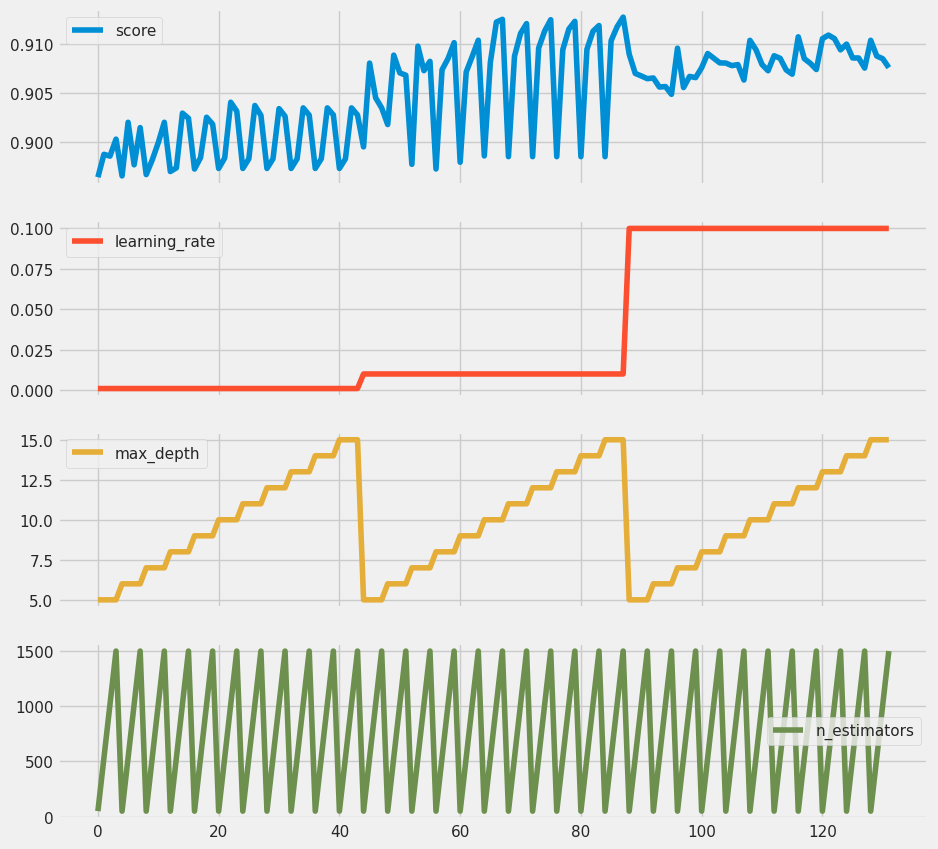

In [41]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [43]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = XGBClassifier(**best_params)

In [44]:
n_iter = 0
auc_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred_proba = model.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가
print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

1 번째 Stratified Stratified K-Fold 정확도: 0.9264411027568923
2 번째 Stratified Stratified K-Fold 정확도: 0.8573607932875668
3 번째 Stratified Stratified K-Fold 정확도: 0.8924485125858123
4 번째 Stratified Stratified K-Fold 정확도: 0.9064327485380118
5 번째 Stratified Stratified K-Fold 정확도: 0.8580600050851768
--------------------------------------------------
교차 검증 auc: 0.888148632450692


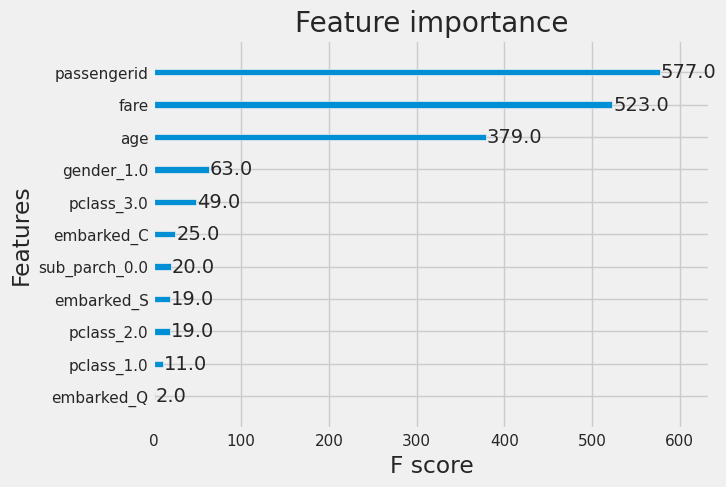

In [45]:
plot_importance(model)
plt.show()

## Light GBM

### model 1

In [46]:
from lightgbm import LGBMClassifier, plot_importance

In [47]:
hp = {
    "random_state" : 42
}
model = LGBMClassifier(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred_proba = model.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가
print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

### model 2

In [48]:
hp = {
    "random_state" : 42,
    "verbose": -1, # 로그
}
model = LGBMClassifier(**hp)

In [49]:
n_iter=50 # 몇번 hp조합을 찾을 것인가?
scoring = 'roc_auc' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

0.9057557349482815

In [50]:
best_params = rs1.best_params_
best_params

{'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

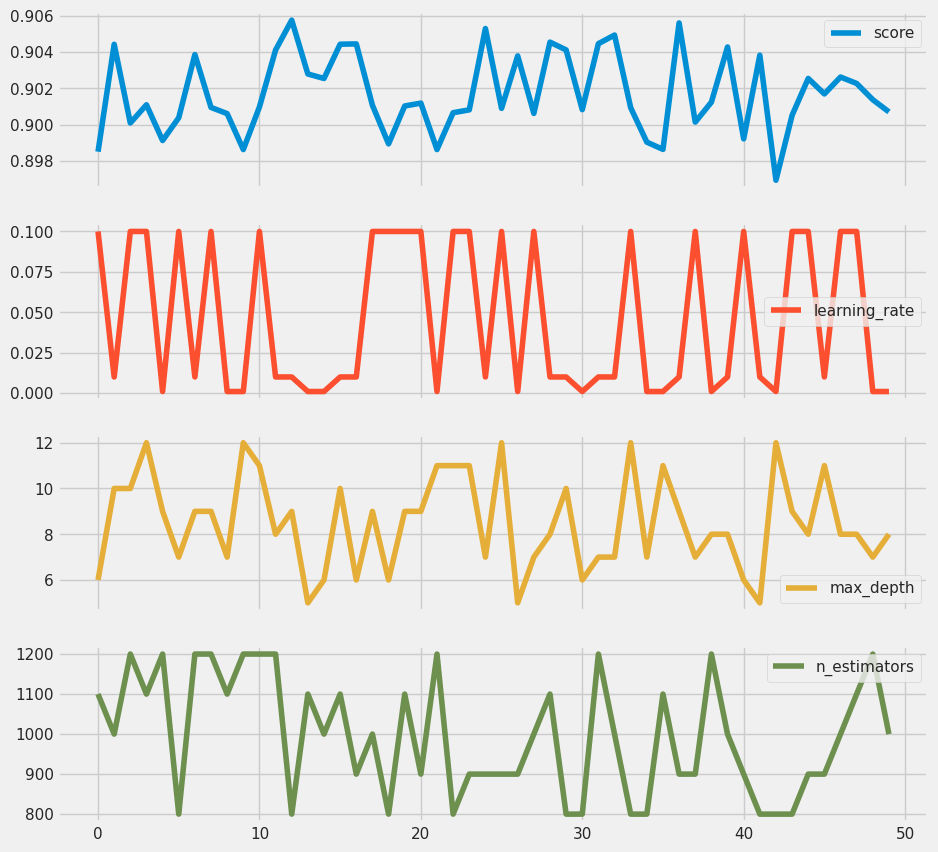

In [51]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [52]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [53]:
best_params['random_state'] = 42
best_params['verbose'] = -1

# best 모델 인스턴스 생성(정의)
best_mode = LGBMClassifier(**best_params)

In [54]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred_proba = model.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가
print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

1 번째 Stratified Stratified K-Fold 정확도: 0.9192982456140351
2 번째 Stratified Stratified K-Fold 정확도: 0.8634630053394355
3 번째 Stratified Stratified K-Fold 정확도: 0.8939740655987796
4 번째 Stratified Stratified K-Fold 정확도: 0.9023646071700991
5 번째 Stratified Stratified K-Fold 정확도: 0.8662598525298754
--------------------------------------------------
교차 검증 auc: 0.8887641809838607


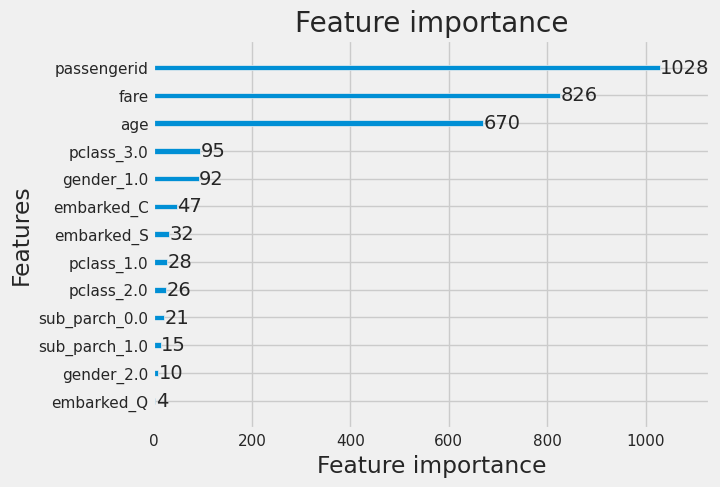

In [55]:
plot_importance(model)
plt.show()

## catboost

### model 1

In [56]:
from catboost import CatBoostClassifier

In [57]:
hp = {
    "random_state" : 42,
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}
model = CatBoostClassifier(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred_proba = model.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가
print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

1 번째 Stratified Stratified K-Fold 정확도: 0.9312030075187971
2 번째 Stratified Stratified K-Fold 정확도: 0.8775743707093822
3 번째 Stratified Stratified K-Fold 정확도: 0.8811339944063057
4 번째 Stratified Stratified K-Fold 정확도: 0.9290617848970253
5 번째 Stratified Stratified K-Fold 정확도: 0.8666412407831172
--------------------------------------------------
교차 검증 auc: 0.890853855653627


### model 2

In [58]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = CatBoostClassifier(**hp)

In [59]:
n_iter=20 # 몇번 hp조합을 찾을 것인가?
scoring = 'roc_auc' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(10,500,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

0.9228539783198169

In [60]:
best_params = rs1.best_params_
best_params

{'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

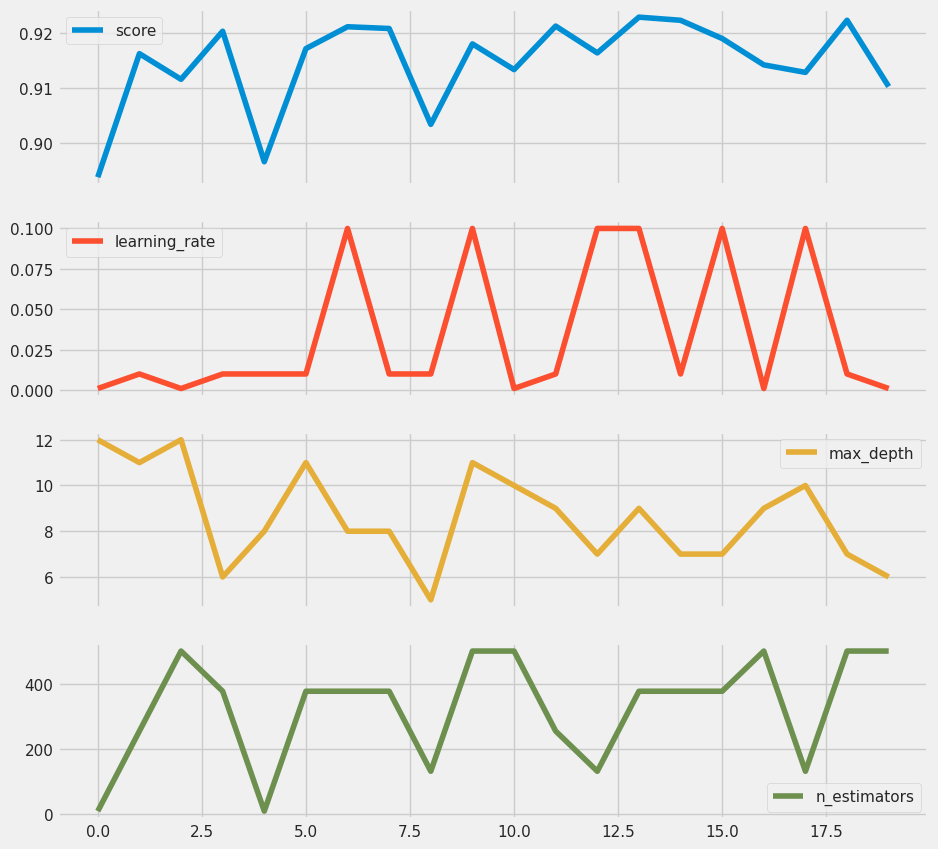

In [61]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [62]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [63]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = LGBMClassifier(**best_params)

In [64]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred_proba = model.predict_proba(valid_x)[:,1] # 예측확률

  # 평가
  fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)
  valid_auc = auc(fpr, tpr)
  auc_lst.append(valid_auc)
  print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

# 최종 평가
print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')

1 번째 Stratified Stratified K-Fold 정확도: 0.9312030075187971
2 번째 Stratified Stratified K-Fold 정확도: 0.8775743707093822
3 번째 Stratified Stratified K-Fold 정확도: 0.8811339944063057
4 번째 Stratified Stratified K-Fold 정확도: 0.9290617848970253
5 번째 Stratified Stratified K-Fold 정확도: 0.8666412407831172
--------------------------------------------------
교차 검증 auc: 0.8921076604554865


Text(0.5, 1.0, 'Feature Importance')

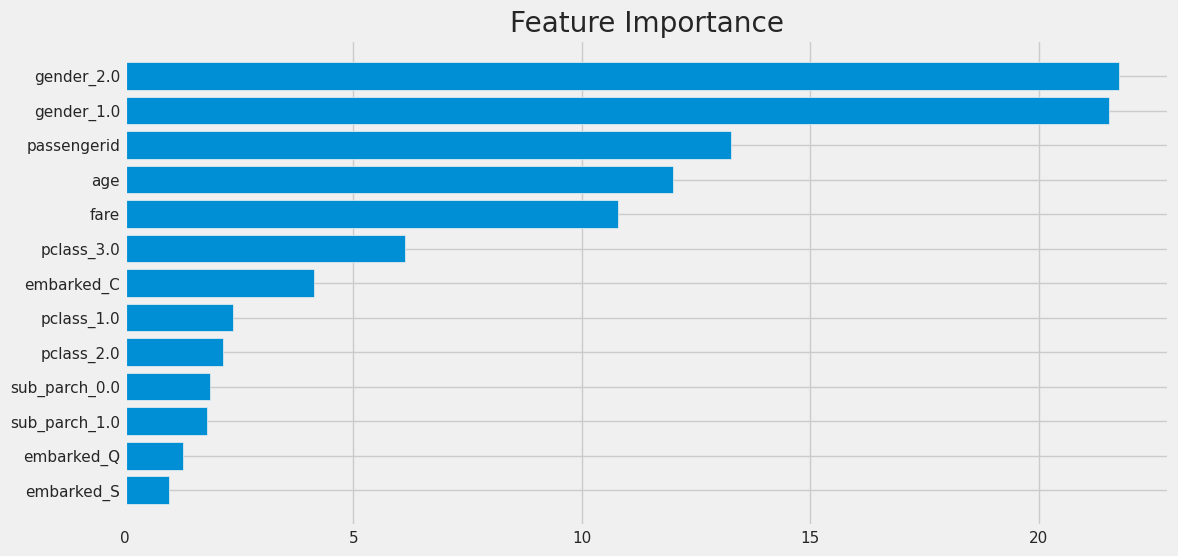

In [65]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(range(len(train_x)))[sorted_idx])
# 변수명이 있다면, 아래와 같이...
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')

# F1-score

In [66]:
model

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [68]:
pred = model.predict(train_x)
pred_proba = model.predict_proba(train_x)

In [69]:
score = accuracy_score(train_y, pred)

In [70]:
f1_score(train_y, pred, average="micro")

0.9290586630286494

In [71]:
f1_score(train_y, pred, average="macro")

0.9234138657150665

In [72]:
f1_score(train_y, pred, average="weighted")

0.9284913467157263

In [73]:
f1_score(train_y, pred)

0.9026217228464419

# 학습 평가

In [74]:
pred = model.predict(train_features) # 예측값
pred_proba = model.predict_proba(train_features)[:,1] # 예측확률

In [75]:
from sklearn.metrics import roc_curve, auc

In [76]:
# roc_curve(실제값, 예측확률값)
fpr, tpr, thresholds = roc_curve(train_target, pred_proba)
print(f'auc: {auc(fpr, tpr)}')

auc: 0.9608660379271879


In [77]:
from sklearn.metrics import confusion_matrix

In [78]:
# confusion_matrix(실제값, 예측값)
# normalize="true" -> 확률값으로 변경!!
conf_mx = confusion_matrix(train_target, pred, normalize="true")
conf_mx

array([[0.95438596, 0.04561404],
       [0.15028902, 0.84971098]])

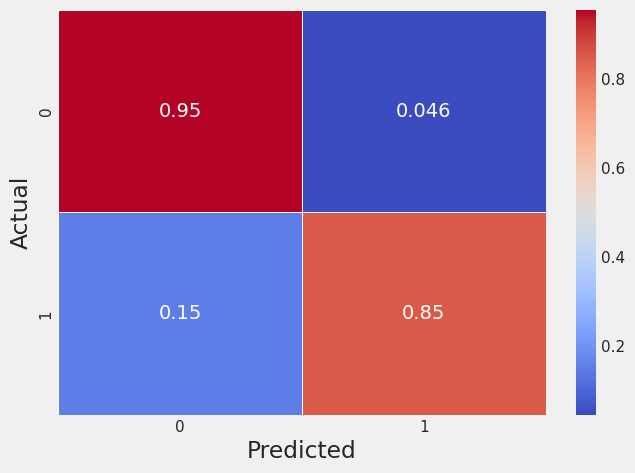

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# annot=True -> 수치데이터 표시
# cmap -> 히트맵 컬러정의
# linewidth -> 선 두께
sns.heatmap(conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [80]:
# pandas의 데이터 프레임을 슬라이싱할때 사용한 모듈은 iloc, loc임!!!
# 인덱스(또는 컬럼)의 조건이 True인 것으로 정의를 하면 사용할 있음
tmp_train = find_s_survived.copy()
tmp_train['pred'] = pred
tmp_train.head()

,passengerid,pclass,age,fare,gender,survived,embarked,sub_parch,sub_sibsp,pred
0,0,2,29.69837,12.8750,male,0,S,0,0,0
1,1,3,29.69837,7.7500,female,0,Q,0,0,0
2,2,1,52.00000,93.5000,female,1,S,1,1,1
3,3,3,27.00000,7.7958,male,1,S,0,0,0
4,4,2,44.00000,26.0000,male,0,S,0,1,0


In [81]:
# FP정의
# 모델은 True & 실제값은 False인 데이터
c1 = tmp_train['survived'] == 0 # 실제값은 False
c2 = tmp_train['pred'] == 1 # 모델은 True
c = c1 & c2

tmp_train.loc[c]

,passengerid,pclass,age,fare,gender,survived,embarked,sub_parch,sub_sibsp,pred
17,17,2,44.00000,26.0000,female,0,S,0,1,1
46,46,3,29.69837,25.4667,female,0,S,1,2,1
88,88,3,45.00000,27.9000,female,0,S,1,1,1
90,90,3,29.69837,25.4667,female,0,S,1,2,1
126,126,3,11.00000,31.2750,female,0,S,1,2,1
161,161,3,29.00000,21.0750,female,0,S,1,0,1
185,185,3,29.69837,56.4958,male,0,S,0,0,1
202,202,3,45.00000,7.7500,female,0,S,0,0,1
235,235,3,18.00000,18.0000,female,0,S,0,2,1
340,340,2,27.00000,21.0000,female,0,S,0,1,1


In [82]:
# FN정의
# 모델은 False & 실제값은 True인 데이터
c1 = tmp_train['survived'] == 1 # 실제값은 True
c2 = tmp_train['pred'] == 0 # 모델은 False
c = c1 & c2

tmp_train.loc[c]

,passengerid,pclass,age,fare,gender,survived,embarked,sub_parch,sub_sibsp,pred
3,3,3,27.00000,7.7958,male,1,S,0,0,0
30,30,3,20.00000,15.7417,male,1,C,1,1,0
62,62,3,29.69837,7.2292,male,1,C,0,0,0
65,65,3,27.00000,6.9750,male,1,S,0,0,0
71,71,3,29.69837,7.7750,male,1,S,0,0,0
78,78,3,29.69837,23.2500,male,1,Q,0,2,0
87,87,1,28.00000,35.5000,male,1,S,0,0,0
89,89,2,32.00000,26.0000,male,1,S,0,1,0
117,117,1,36.00000,26.3875,male,1,S,0,0,0
118,118,3,44.00000,7.9250,male,1,S,0,0,0


# 예측

In [83]:
target_pred = model.predict_proba(test_encoded)[:,1]
test_encoded.shape, target_pred.shape

((393, 13), (393,))

In [84]:
submission['survived'] = target_pred
submission.head()

,passengerid,survived
0,916,0.758423
1,917,0.832146
2,918,0.895278
3,919,0.034982
4,920,0.902165


In [85]:
submission.to_csv("submission_pagp.csv", header=True, index=False)